<a href="https://colab.research.google.com/github/javier-jaime/Stock_Price_Forecasting/blob/main/Update9_BTC_Price_Forecasting_with_yfinance_and_Facebook_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Bitcoin Price Forecasting with yfinance and Facebook Prophet**

## Importing all the necessary Libraries

In [3]:
!pip install yfinance
import yfinance as yf
import pandas as pd
import numpy as np
import plotly.express as px
from prophet import Prophet
import plotly.io as pio
pio.renderers.default='colab'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Importing the Dataset & Exploring it

In [30]:
 # Stock Ticker Input
stock = input('Enter the stock ticker: ')
print(f'You entered {stock}, here is the data from the last 10 days:')
period = '3y'
ticker = yf.Ticker(stock)
data = ticker.history(period)
data.reset_index(inplace=True)
data.tail(10)

Enter the stock ticker: BTC-USD
You entered BTC-USD, here is the data from the last 10 days:


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
1087,2022-09-03,19969.718750,20037.009766,19698.355469,19832.087891,23613051457,0,0
1088,2022-09-04,19832.470703,19999.689453,19636.816406,19986.712891,25245861652,0,0
1089,2022-09-05,19988.789062,20031.160156,19673.046875,19812.371094,28813460025,0,0
1090,2022-09-06,19817.724609,20155.269531,18800.171875,18837.667969,43403978910,0,0
1091,2022-09-07,18837.683594,19427.171875,18644.466797,19290.324219,35239757134,0,0
1092,2022-09-08,19289.941406,19417.351562,19076.714844,19329.833984,32194477850,0,0
1093,2022-09-09,19328.140625,21439.410156,19310.962891,21381.152344,48469528171,0,0
1094,2022-09-10,21376.912109,21760.275391,21168.722656,21680.539062,36913738894,0,0
1095,2022-09-11,21678.542969,21770.552734,21406.945312,21769.255859,34493951963,0,0
1096,2022-09-12,21757.916016,22433.746094,21607.703125,22301.531250,49477963776,0,0


In [31]:
print('These are the basic stats:')
data.describe()

These are the basic stats:


,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,1097.000000,1097.000000,1097.000000,1097.000000,1.097000e+03,1097.0,1097.0
mean,27870.096183,28573.099364,27079.016642,27877.087687,3.558246e+10,0.0,0.0
std,17994.570119,18466.175788,17438.696570,17981.893954,1.883744e+10,0.0,0.0
min,5002.578125,5331.833984,4106.980957,4970.788086,1.204343e+10,0.0,0.0
25%,9655.854492,9804.793945,9483.003906,9656.717773,2.409742e+10,0.0,0.0
50%,23652.070312,24127.414062,23009.949219,23656.207031,3.210423e+10,0.0,0.0
75%,42944.976562,43903.019531,41982.617188,42892.957031,4.249439e+10,0.0,0.0
max,67549.734375,68789.625000,66382.062500,67566.828125,3.509679e+11,0.0,0.0


# Data Visualization (plotly express) - Visualizing the historical performance

In [32]:
#Line graph (Price), Area graph (Volume) , box plot (Analyzing price and volume)

In [33]:
px.line(data, x="Date", y="Close", title=f'{stock} Stock Close Price')

In [34]:
px.bar(data, x="Date", y="Volume", title=f'{stock} Stock Volume')

In [35]:
px.box(data, y="Close", title=f'{stock} box plot', height=500, width=500)

In [36]:
def get_hurst_exponent(time_series, max_lag=100):
    """Returns the Hurst Exponent of the time series"""
    lags = range(2, max_lag)
    # variances of the lagged differences
    tau = [np.std(np.subtract(time_series[lag:], time_series[:-lag])) for lag in lags]
    # calculate the slope of the log plot -> the Hurst Exponent
    reg = np.polyfit(np.log(lags), np.log(tau), 1)
    return reg[0]

In [37]:
hurst = pd.DataFrame(columns =["hurst_exp","lag"])
lags = range(4, 121, 1)
for lag in lags:
    hurst_exp = get_hurst_exponent(data["Close"].values, lag)
    hurst = hurst.append({"hurst_exp":hurst_exp,"lag":lag},ignore_index=True)
px.line(hurst, x="hurst_exp", y="lag", title=f'{stock} Hurst Exp')

## Data Preparation for Facebook Prophet

In [38]:
columns=['Date','Close']
prophet_df=pd.DataFrame(data,columns=columns)
prophet_df= prophet_df.rename(columns={'Date':'ds','Close':'y'})  
prophet_df.tail()

,ds,y
1092,2022-09-08,19329.833984
1093,2022-09-09,21381.152344
1094,2022-09-10,21680.539062
1095,2022-09-11,21769.255859
1096,2022-09-12,22301.531250


## Creating Facebook Prophet Model

In [39]:
m=Prophet(daily_seasonality=False)
m.fit(prophet_df)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpuuu8rmc3/hx0_w6vu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuuu8rmc3/r2_wcncf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84224', 'data', 'file=/tmp/tmpuuu8rmc3/hx0_w6vu.json', 'init=/tmp/tmpuuu8rmc3/r2_wcncf.json', 'output', 'file=/tmp/tmp054jq44s/prophet_model-20220912153631.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:36:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:36:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


##Forecasting

In [40]:
periods = 30
future=m.make_future_dataframe(periods)

In [41]:
forecast=m.predict(future)

In [42]:
forecast.head(10)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-09-12,8702.269628,4268.214187,12100.288078,8702.269628,8702.269628,-764.760092,-764.760092,-764.760092,-32.776432,-32.776432,-32.776432,-731.983660,-731.983660,-731.983660,0.0,0.0,0.0,7937.509536
1,2019-09-13,8693.084855,3992.868691,11961.089446,8693.084855,8693.084855,-894.523470,-894.523470,-894.523470,-28.266250,-28.266250,-28.266250,-866.257220,-866.257220,-866.257220,0.0,0.0,0.0,7798.561385
2,2019-09-14,8683.900082,3656.506340,11714.334371,8683.900082,8683.900082,-999.606680,-999.606680,-999.606680,-0.577449,-0.577449,-0.577449,-999.029231,-999.029231,-999.029231,0.0,0.0,0.0,7684.293402
3,2019-09-15,8674.715309,3559.615354,11638.971464,8674.715309,8674.715309,-1123.860339,-1123.860339,-1123.860339,5.530050,5.530050,5.530050,-1129.390389,-1129.390389,-1129.390389,0.0,0.0,0.0,7550.854969
4,2019-09-16,8665.530535,3508.376805,11233.129998,8665.530535,8665.530535,-1231.715492,-1231.715492,-1231.715492,24.612621,24.612621,24.612621,-1256.328113,-1256.328113,-1256.328113,0.0,0.0,0.0,7433.815043
5,2019-09-17,8656.345762,3344.119529,11340.286302,8656.345762,8656.345762,-1415.309168,-1415.309168,-1415.309168,-36.584778,-36.584778,-36.584778,-1378.724390,-1378.724390,-1378.724390,0.0,0.0,0.0,7241.036594
6,2019-09-18,8647.160989,3290.668864,10878.154517,8647.160989,8647.160989,-1427.295775,-1427.295775,-1427.295775,68.062238,68.062238,68.062238,-1495.358014,-1495.358014,-1495.358014,0.0,0.0,0.0,7219.865214
7,2019-09-19,8637.976216,2808.312086,11051.724337,8637.976216,8637.976216,-1637.687944,-1637.687944,-1637.687944,-32.776432,-32.776432,-32.776432,-1604.911512,-1604.911512,-1604.911512,0.0,0.0,0.0,7000.288272
8,2019-09-20,8628.791443,2855.923876,10583.520705,8628.791443,8628.791443,-1734.249164,-1734.249164,-1734.249164,-28.266250,-28.266250,-28.266250,-1705.982913,-1705.982913,-1705.982913,0.0,0.0,0.0,6894.542279
9,2019-09-21,8619.606669,3016.348764,10943.494374,8619.606669,8619.606669,-1797.679776,-1797.679776,-1797.679776,-0.577449,-0.577449,-0.577449,-1797.102327,-1797.102327,-1797.102327,0.0,0.0,0.0,6821.926893


In [43]:
px.line(forecast, x='ds',y='yhat', title=f'{stock} Stock Forecast')

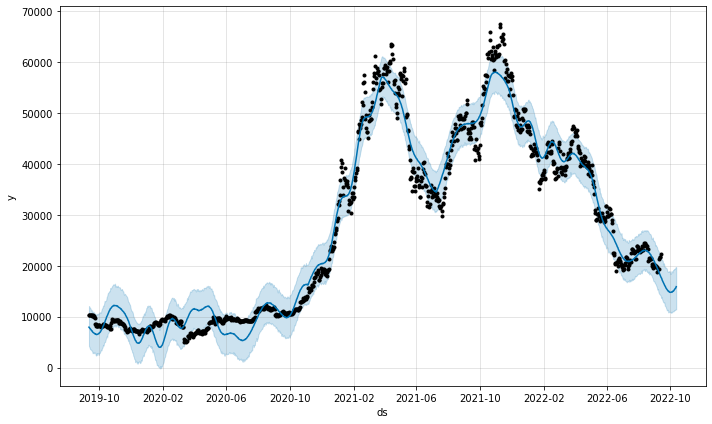

In [44]:
figure=m.plot(forecast, xlabel='ds', ylabel='y')

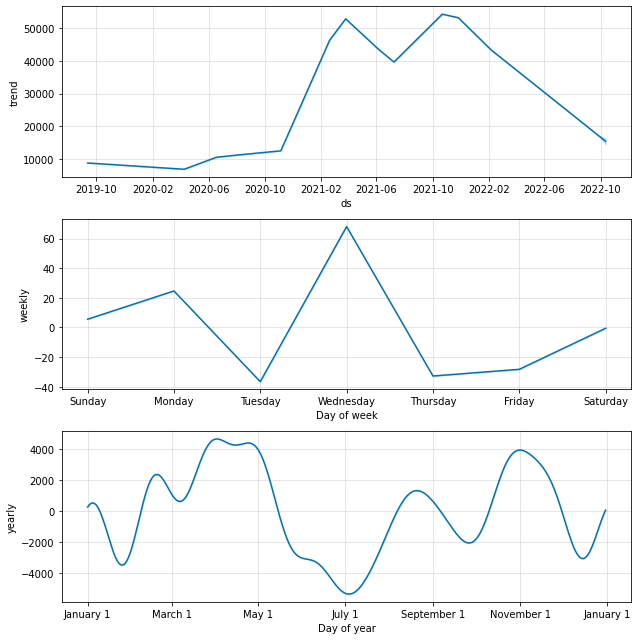

In [45]:
figure2=m.plot_components(forecast)

##Downloading the Forecast data

In [46]:
from google.colab import files
forecast.to_csv(f'{stock}_forecast.csv')
files.download(f'{stock}_forecast.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>